In [11]:
import numpy as np
def hill(K,s,b,x):
#hill function
    return s*x/(K + x)+b


def make_x(K, amp, basal, x, fraction, sigmas, num_cells, boundaries):
    #makes x with 2 log-normal distributions. Kind of looks like real data
    y = hill(K,amp,basal,x)
    mu = np.log((y - (1 - fraction) * basal)/fraction) - sigmas[1]**2/2.
    mu0 = np.log(basal) - sigmas[0]**2/2.
    bound   = sigmas[1] * np.random.randn(int(np.round(num_cells*fraction)))+mu
    unbound = sigmas[0] * np.random.randn(int(np.round(num_cells*(1-fraction))))+mu0
    bound = np.hstack((bound, unbound))
    bound = np.exp(bound)
    x = np.histogram(bound, bins=boundaries)[0]
    return x, bound

def generate_bound(K, s, basal, fl, boundaries, sigmas, num_cells):
    #Generates a fake sort distribution for the data, truex, and then turns that into noisy sequencing data R
    truex = []
    R = []
    bounds = []
    for ii, f in enumerate(fl):
        x, bound = make_x(K, s, basal, f, 0.8, sigmas, num_cells, boundaries)
        bounds.append(bound)
        
    return bounds


def generate_counts(K, s, basal, k, S, T, fl, boundaries, sigmas):
    #Generates a fake sort distribution for the data, truex, and then turns that into noisy sequencing data R
    truex = []
    R = []
    bounds = []
    for ii, f in enumerate(fl):
        x, bound = make_x(K, s, basal, f, 0.8, sigmas, np.max([k*np.sum(S[ii]), 10]), boundaries)
        bounds.append(bound)
        x= np.array(x, dtype = float)/float(np.sum(x))
        x*=k/np.sum(x)
        truex.append(x)
        Sx = x * S[ii].sum()
        p = Sx / S[ii]
        p[p>1] = 1
        scale = 10**(np.random.rand()*4-2)
        #scale = 1
        R.append([float(np.random.binomial(int(T[ii][jj]/scale), p[jj])*scale) for jj in range(4)])
    
    truex = np.array(truex)
    R = np.array(R)
    return R, truex, bounds

In [18]:
import numpy as np
import pdb
import pandas
from KD_fit_log_poiss import x_star
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sys
#from make_simulated import *
active_replicate = 0 #int(sys.argv[1])
up_scale = 1.0 # float(sys.argv[2])
np.random.seed(active_replicate)

#########################################################
# experimental data
#########################################################
# fluorescein concentrations
fl = np.hstack((np.zeros(1),np.logspace(-9.5, -5, 10)))

#total read counts. Should be good but uneven
x = ['0', '10^-9.5', '10^-9', '10^-8.5', '10^-8', '10^-7.5', '10^-7', '10^-6.5', '10^-6', '10^-5.5', '10^-5']

#total read counts taken from data
replicate = pandas.read_csv('./data/replicate_'+str(active_replicate+1) + '.csv')

T = np.zeros((11,4))
for ii in range(len(x)):
    for jj in range(4):
        T[ii,jj] = np.sum(replicate['fluorescein'+x[ii]+'bin'+str(jj)])

#scale up the read counts for ideal data
T = T * up_scale

# fraction of population estimated from sequencing data
ks = replicate['fit_fraction']

# total sort counts. taken from experimental data
sort_counts_16_4_15 = np.array([[3.02E+06,	2.56E+06,	3.56E+06,	2.41E+06],
[4.99E+06,	5.92E+06,	1.39E+04,	2.72E+02],
[2.24E+06,	4.00E+06,	1.21E+06,	3.87E+04],
[1.67E+06,	3.62E+06,	1.57E+06,	2.35E+05],
[2.48E+06,	3.12E+06,	1.54E+06,	5.90E+05],
[1.91E+06,	3.16E+06,	1.42E+06,	8.60E+05],
[2.05E+06,	3.34E+06,	1.52E+06,	1.05E+06],
[1.09E+06,	1.95E+06,	1.00E+06,	8.39E+05],
[1.43E+06,	2.02E+06,	1.07E+06,	1.00E+06],
[1.98E+06,	2.67E+06,	1.47E+06,	1.46E+06],
[1.17E+06,	2.00E+06,	1.02E+06,	1.37E+06],
[3.02E+06,	5.47E+06,	2.69E+06,	2.83E+06]])

sort_counts_16_4_19 = np.array([[3.41E+06,	1.98E+06,	3.68E+06,	2.41E+06],
[2.60E+06,	5.79E+06,	1.63E+05,	3.56E+02],
[6.66E+05,	1.98E+06,	3.85E+05,	1.63E+05],
[6.18E+05,	1.80E+06,	5.60E+05,	3.21E+05],
[9.90E+05,	2.61E+06,	7.22E+05,	6.32E+05],
[1.50E+06,	3.40E+06,	8.80E+05,	9.81E+05],
[1.44E+06,	3.45E+06,	8.88E+05,	1.08E+06],
[1.03E+06,	2.46E+06,	6.74E+05,	8.84E+05],
[8.11E+05,	2.06E+06,	5.70E+05,	7.71E+05],
[1.43E+06,	3.39E+06,	8.81E+05,	1.31E+06],
[1.20E+06,	2.91E+06,	7.36E+05,	1.19E+06],
[1.38E+06,	3.89E+06,	1.09E+06,	1.79E+06]])

sort_counts_16_4_21 = np.array([[4.99E+06,	2.98E+06,	3.39E+06,	1.32E+06],
[5.21E+06,	5.88E+06,	2.19E+04,	2.33E+02],
[2.33E+06,	4.05E+06,	1.32E+06,	1.10E+05],
[2.41E+06,	3.89E+06,	1.69E+06,	5.77E+05],
[2.59E+06,	3.70E+06,	1.57E+06,	1.09E+06],
[2.53E+06,	3.51E+06,	1.53E+06,	1.35E+06],
[2.34E+06,	2.45E+06,	1.24E+06,	1.26E+06],
[2.36E+06,	2.44E+06,	1.31E+06,	1.44E+06],
[1.73E+06,	2.15E+06,	1.09E+06,	1.32E+06],
[2.78E+06,	2.83E+06,	1.49E+06,	1.92E+06],
[1.54E+06,	2.08E+06,	9.75E+05,	1.28E+06],
[2.30E+06,	2.58E+06,	1.53E+06,	2.00E+06]])

#sort counts amplified for ideal data
S = [sort_counts_16_4_15, sort_counts_16_4_19, sort_counts_16_4_21]
S = S[active_replicate][1:] * up_scale# choose the selected sort stats, then remove the first row, since it describes expression sorts

# Relates read counts to sort counts. 
b = np.array([(np.sum(sorts)/sorts).tolist() for sorts in S])

# bin boundaries
# April 15 gates
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, 5.2856967691125885]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, 5.2856967691125885]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,5.2856967691125885]])
#########################################################################
bin_vals = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]
bin_vals = bin_vals[active_replicate]

delta = np.mean([bin_vals[2,1]-bin_vals[2,0], bin_vals[1,1]-bin_vals[1,0]])
c = 10**(delta*np.array(range(4)))

boundaries = np.array([0, 10**bin_vals[0,1], 10**bin_vals[1,1], 10**bin_vals[2,1], np.inf])

########
# basal mean values taken from flow cytometry reports
##########
basal = [194, 243, 177]
basal = basal[active_replicate]

######################
# end of experimental data
######################
#######################
# Simulate cells
#######################
true_K = []

bin_range = bin_vals[3,1] - bin_vals[3,0]
R = []

KD_scan = np.logspace(-10, -4, 71)
s_scan = np.logspace(np.log10(c[0]),np.log10(c[3])-0.02, 70)
fitk = []
stds = []

for kk, k in enumerate(ks):
    amplitude = 10**bin_vals[3,0] + np.random.rand()*10**bin_range 
    KD = 10 ** (-6 * np.random.rand() - 4)
    temp_R, temp_x, fc_bound = generate_counts(KD, amplitude, basal, k, S, T, fl, boundaries, [np.sqrt(1), np.sqrt(0.5)])
    true_K.append(KD)
    R.append(temp_R)
    x, KD, s, KD_sigma, get_obj, prob, log_prob, try_LL, k_guess = x_star(temp_R, T, b, [k], c, temp_x[0].dot(c)/temp_x[0].sum(), KD_scan, s_scan, fl)

    #program gets inf and nan errors if there is no data.
    if np.sum(R)==0:
        fitk.append(1)
        stds.append(np.inf)    
    else:    
        fitk.append(KD)
        stds.append(KD_sigma)
    
    print(f'{kk} of {len(ks)} True KD:' + str(true_K[-1]) + ' Fit KD: ' + str(fitk[-1]))

out_dict = dict()
out_dict['true_KD'] = true_K
out_dict['fit_KD'] = fitk
out_dict['fit_KD_std'] = stds
out = pandas.DataFrame(out_dict, columns = np.sort(out_dict.keys()))
out.to_csv('data/ideal_'+str(active_replicate)+'_'+str(up_scale)+'.csv')

In [15]:
k

0.000230520443261

In [46]:
R, truex, bounds = generate_counts(KD, amplitude, basal, k, S, T, fl, boundaries, [np.sqrt(1), np.sqrt(0.5)])

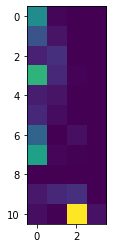

In [47]:
plt.imshow(R)

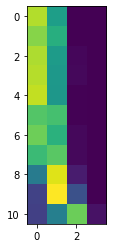

In [48]:
plt.imshow(truex)